In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm

In [2]:
# Implement from scratch the following normalization schemes. They should
# be implemented as a sub-class of torch.nn.Module.

# (a) Batch Normalization (BN) [3]
# (b) Instance Normalization (IN) [7]
# (c) Batch-Instance Normalization (BIN) [4]
# (d) Layer Normalization (LN) [1]
# (e) Group Normalization (GN) [8]

import torch
import torch.nn as nn

class NoNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(NoNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        return x

class BatchNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        # shape = (1, num_features, 1, 1)
        
    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class InstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(InstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[2, 3], keepdim=True)
            variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

  

class BatchInstanceNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchInstanceNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = 0
        self.running_var = 0
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[0, 2, 3])
            variance = x.var(dim=[0, 2, 3])
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var
        x = (x - mean.view(1, -1, 1, 1)) / (variance.view(1, -1, 1, 1) + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        mean = x.mean(dim=[2, 3], keepdim=True)
        variance = x.var(dim=[2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x

    

class LayerNormalise(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(LayerNormalise, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        shape = (1, num_features, 1, 1)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        else:
            mean = x.mean(dim=[1, 2, 3], keepdim=True)
            variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        return x
    

class GroupNormalise(nn.Module):
    def __init__(self, num_features, num_groups=4, eps=1e-5, momentum=0.1):
        super(GroupNormalise, self).__init__()
        self.num_features = num_features
        self.num_groups = num_groups
        self.eps = eps
        self.momentum = momentum
        self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, self.num_groups, int(C / self.num_groups), H, W)
        mean = x.mean(dim=[1, 2, 3], keepdim=True)
        variance = x.var(dim=[1, 2, 3], keepdim=True)
        x = (x - mean) / (variance + self.eps).sqrt()
        x = x.view(N, C, H, W)
        x = self.gamma * x + self.beta
        return x

In [3]:
def norms(dimension, norm_type):
    if norm_type == 'none':
        return NoNormalise(dimension)
    elif norm_type == 'batch':
        return BatchNormalise(dimension)
    elif norm_type == 'instance':
        return InstanceNormalise(dimension)
    elif norm_type == 'batchinstance':
        return BatchInstanceNormalise(dimension)
    elif norm_type == 'layer':
        return LayerNormalise(dimension)
    elif norm_type == 'group':
        return GroupNormalise(dimension)
    else:
        raise ValueError('Invalid norm type')
    

class resd_block(nn.Module):
    def __init__(self, in_chs, out_chs, downsampling=None, stride=1, norm_type='none'):
        super(resd_block, self).__init__()
        self.conv1 = nn.Conv2d(in_chs, out_chs, kernel_size=3, stride=stride, padding=1)
        self.bn1 = norms(out_chs, norm_type)
        self.conv2 = nn.Conv2d(out_chs, out_chs, kernel_size=3, stride=1, padding=1)
        self.bn2 = norms(out_chs, norm_type)
        self.downsampling = downsampling
        self.relu = nn.ReLU()
        self.out_chs = out_chs

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampling is not None:
            identity = self.downsampling(x)
        out += identity
        out = self.relu(out)
        return out
    

class resnet(nn.Module): # n layers of blocks, r classes
    def __init__(self, resd_block, layers, img_chs, r, norm_type):
        super(resnet, self).__init__()
        self.in_chs = 16
        self.conv1 = nn.Conv2d(img_chs, 16, kernel_size=3, stride=1, padding=1)
        self.bn = norms(16, norm_type)
        self.relu = nn.ReLU()
        self.layer1 = self.add_layer(resd_block, 16, layers[0], 1, norm_type)
        self.layer2 = self.add_layer(resd_block, 32, layers[1], 2, norm_type)
        self.layer3 = self.add_layer(resd_block, 64, layers[2], 2, norm_type)
        self.avg_pool = nn.AvgPool2d(kernel_size=64)
        self.fc = nn.Linear(64, r)

    def add_layer(self, resd_block, out_chs, n, stride, norm_type):
        downsampling = None
        if (stride != 1) or (self.in_chs != out_chs):
            downsampling = nn.Sequential(nn.Conv2d(self.in_chs, out_chs, kernel_size=3, stride=stride, padding=1), norms(out_chs, norm_type))
        layers = []
        layers.append(resd_block(self.in_chs, out_chs, downsampling, stride, norm_type))
        self.in_chs = out_chs

        for i in range(1, n):
            layers.append(resd_block(self.in_chs, out_chs, norm_type=norm_type))
            
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

def final_resnet(img_chs, r, n, norm_type):
    return resnet(resd_block, [n, n, n], img_chs, r, norm_type)

In [4]:
# The hyperparameters

n = 2
r = 25
batch_size = 32
# learning_rate = 0.0001
num_epochs = 50 
num_workers = 4
norm_type = 'group'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Device: ", device)

Device:  cuda:0


Train Data:  29417
Validation Data:  8413
------------------------Training Started------------------------


100%|██████████| 263/263 [00:21<00:00, 12.48it/s]


Epoch:  0 Train Loss:  0.08969368360650189 Train Accuracy:  13.02988068123874 Train F1 Macro:  0.11434047168076882 Train F1 Micro:  0.1302988068123874
Epoch:  0 Validation Loss:  0.08418723350329022 Validation Accuracy:  14.441935100439796 Validation F1 Macro:  0.10773980941924448 Validation F1 Micro:  0.14441935100439796
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.46it/s]


Epoch:  1 Train Loss:  0.07839874671423554 Train Accuracy:  21.89890199544481 Train F1 Macro:  0.20088507576506612 Train F1 Micro:  0.21898901995444808
Epoch:  1 Validation Loss:  0.07474514163661256 Validation Accuracy:  26.304528705574704 Validation F1 Macro:  0.24068855870647846 Validation F1 Micro:  0.26304528705574703
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.43it/s]


Epoch:  2 Train Loss:  0.07308068191404998 Train Accuracy:  26.532277254648672 Train F1 Macro:  0.2514241053317775 Train F1 Micro:  0.26532277254648673
Epoch:  2 Validation Loss:  0.07019734962168196 Validation Accuracy:  30.262688696065617 Validation F1 Macro:  0.28418591667339693 Validation F1 Micro:  0.30262688696065615
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.41it/s]


Epoch:  3 Train Loss:  0.06973284434124578 Train Accuracy:  30.09824251283272 Train F1 Macro:  0.2879837790616337 Train F1 Micro:  0.3009824251283272
Epoch:  3 Validation Loss:  0.06789817578243072 Validation Accuracy:  31.130393438725783 Validation F1 Macro:  0.30089944930842316 Validation F1 Micro:  0.31130393438725784
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.37it/s]


Epoch:  4 Train Loss:  0.06721830994542184 Train Accuracy:  32.30105041302648 Train F1 Macro:  0.3115827703794848 Train F1 Micro:  0.32301050413026483
Epoch:  4 Validation Loss:  0.0649045025226861 Validation Accuracy:  35.08855342921669 Validation F1 Macro:  0.3374661983396258 Validation F1 Micro:  0.3508855342921669
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.44it/s]


Epoch:  5 Train Loss:  0.06518635489004783 Train Accuracy:  34.52085528775878 Train F1 Macro:  0.33459730398703236 Train F1 Micro:  0.3452085528775878
Epoch:  5 Validation Loss:  0.06337031205230699 Validation Accuracy:  35.93248543920124 Validation F1 Macro:  0.3565201429334137 Validation F1 Micro:  0.35932485439201234
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.33it/s]


Epoch:  6 Train Loss:  0.06357694947873971 Train Accuracy:  35.846619301764285 Train F1 Macro:  0.34859705168114385 Train F1 Micro:  0.3584661930176428
Epoch:  6 Validation Loss:  0.0632938276456055 Validation Accuracy:  35.706644478782835 Validation F1 Macro:  0.3464529878834773 Validation F1 Micro:  0.3570664447878284
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.47it/s]


Epoch:  7 Train Loss:  0.06230123250056615 Train Accuracy:  37.26416697827787 Train F1 Macro:  0.3637082042924033 Train F1 Micro:  0.37264166978277874
Epoch:  7 Validation Loss:  0.06138480233193917 Validation Accuracy:  37.79864495423749 Validation F1 Macro:  0.37200839283929604 Validation F1 Micro:  0.3779864495423748
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.39it/s]


Epoch:  8 Train Loss:  0.06109653427935021 Train Accuracy:  38.01543325288099 Train F1 Macro:  0.37265921881300385 Train F1 Micro:  0.3801543325288099
Epoch:  8 Validation Loss:  0.059726244442870724 Validation Accuracy:  39.33198621181504 Validation F1 Macro:  0.3862059648075381 Validation F1 Micro:  0.39331986211815045
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.43it/s]


Epoch:  9 Train Loss:  0.059921857039625395 Train Accuracy:  39.04884930482374 Train F1 Macro:  0.3829450453490685 Train F1 Micro:  0.3904884930482374
Epoch:  9 Validation Loss:  0.05964665425372127 Validation Accuracy:  39.08237251872102 Validation F1 Macro:  0.377397534356799 Validation F1 Micro:  0.39082372518721026
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.44it/s]


Epoch:  10 Train Loss:  0.058897321162697296 Train Accuracy:  40.092463541489614 Train F1 Macro:  0.39433368656388984 Train F1 Micro:  0.40092463541489615
Epoch:  10 Validation Loss:  0.056993197575769455 Validation Accuracy:  42.25603233091644 Validation F1 Macro:  0.41344213299789506 Validation F1 Micro:  0.4225603233091644
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.41it/s]


Epoch:  11 Train Loss:  0.057828446550113474 Train Accuracy:  41.085086854539895 Train F1 Macro:  0.4051445211798012 Train F1 Micro:  0.410850868545399
Epoch:  11 Validation Loss:  0.05605283446506358 Validation Accuracy:  43.373350766670626 Validation F1 Macro:  0.42459031233291106 Validation F1 Micro:  0.43373350766670626
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.40it/s]


Epoch:  12 Train Loss:  0.05685146030337586 Train Accuracy:  41.96892953054356 Train F1 Macro:  0.41411277008740427 Train F1 Micro:  0.41968929530543564
Epoch:  12 Validation Loss:  0.0561983720961244 Validation Accuracy:  43.02864614287412 Validation F1 Macro:  0.4271540517399706 Validation F1 Micro:  0.4302864614287412
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.43it/s]


Epoch:  13 Train Loss:  0.05595898168693325 Train Accuracy:  42.96155284359384 Train F1 Macro:  0.4250061696887004 Train F1 Micro:  0.4296155284359384
Epoch:  13 Validation Loss:  0.05530424744624042 Validation Accuracy:  42.96921431118507 Validation F1 Macro:  0.42885691220495986 Validation F1 Micro:  0.4296921431118508
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.37it/s]


Epoch:  14 Train Loss:  0.05518680452494049 Train Accuracy:  43.75021246218173 Train F1 Macro:  0.4326054488420198 Train F1 Micro:  0.4375021246218173
Epoch:  14 Validation Loss:  0.05455621997283923 Validation Accuracy:  43.373350766670626 Validation F1 Macro:  0.42941031132886026 Validation F1 Micro:  0.43373350766670626
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.39it/s]


Epoch:  15 Train Loss:  0.054479254419865134 Train Accuracy:  44.51847571132338 Train F1 Macro:  0.4410474804725293 Train F1 Micro:  0.4451847571132338
Epoch:  15 Validation Loss:  0.05282143386439309 Validation Accuracy:  45.03744205396411 Validation F1 Macro:  0.44389892096122147 Validation F1 Micro:  0.45037442053964105
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.33it/s]


Epoch:  16 Train Loss:  0.053632010953060104 Train Accuracy:  45.10317163544889 Train F1 Macro:  0.4471571002605346 Train F1 Micro:  0.4510317163544889
Epoch:  16 Validation Loss:  0.051994535474676334 Validation Accuracy:  47.176987994769995 Validation F1 Macro:  0.4690826915280242 Validation F1 Micro:  0.4717698799477
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.40it/s]


Epoch:  17 Train Loss:  0.05297013501783488 Train Accuracy:  45.80344698643641 Train F1 Macro:  0.4546207473538933 Train F1 Micro:  0.4580344698643641
Epoch:  17 Validation Loss:  0.05186062815653276 Validation Accuracy:  46.85605610364911 Validation F1 Macro:  0.45770709693663847 Validation F1 Micro:  0.46856056103649113
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.40it/s]


Epoch:  18 Train Loss:  0.052239492853197546 Train Accuracy:  46.66689329299385 Train F1 Macro:  0.46317256988543876 Train F1 Micro:  0.4666689329299385
Epoch:  18 Validation Loss:  0.05150002606711687 Validation Accuracy:  46.03589682634019 Validation F1 Macro:  0.4541862118211306 Validation F1 Micro:  0.4603589682634019
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.44it/s]


Epoch:  19 Train Loss:  0.0517828099063119 Train Accuracy:  47.190400108780636 Train F1 Macro:  0.46846664532867116 Train F1 Micro:  0.4719040010878064
Epoch:  19 Validation Loss:  0.0515954642336646 Validation Accuracy:  47.08189706406751 Validation F1 Macro:  0.46046742653762496 Validation F1 Micro:  0.4708189706406751
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.34it/s]


Epoch:  20 Train Loss:  0.05084898547449957 Train Accuracy:  48.16602644729238 Train F1 Macro:  0.4783432303098109 Train F1 Micro:  0.4816602644729238
Epoch:  20 Validation Loss:  0.05049509298896359 Validation Accuracy:  48.13978366813265 Validation F1 Macro:  0.4718965075080525 Validation F1 Micro:  0.4813978366813265
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.37it/s]


Epoch:  21 Train Loss:  0.050344631102706185 Train Accuracy:  48.57055444130945 Train F1 Macro:  0.4826481141465034 Train F1 Micro:  0.4857055444130945
Epoch:  21 Validation Loss:  0.05023078721569705 Validation Accuracy:  49.69689765838583 Validation F1 Macro:  0.4954076358973491 Validation F1 Micro:  0.4969689765838583
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.24it/s]


Epoch:  22 Train Loss:  0.049852908786215164 Train Accuracy:  49.090661862188526 Train F1 Macro:  0.4879516736015712 Train F1 Micro:  0.49090661862188534
Epoch:  22 Validation Loss:  0.04797243165102666 Validation Accuracy:  50.77855699512659 Validation F1 Macro:  0.5042345271059424 Validation F1 Micro:  0.5077855699512659
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.38it/s]


Epoch:  23 Train Loss:  0.049082748488817086 Train Accuracy:  49.943909984022845 Train F1 Macro:  0.49661417396720614 Train F1 Micro:  0.49943909984022844
Epoch:  23 Validation Loss:  0.04887301504831599 Validation Accuracy:  50.26744324260074 Validation F1 Macro:  0.4986555333466122 Validation F1 Micro:  0.5026744324260074
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.36it/s]


Epoch:  24 Train Loss:  0.04855197032052242 Train Accuracy:  50.40282829656321 Train F1 Macro:  0.5014923861707019 Train F1 Micro:  0.5040282829656321
Epoch:  24 Validation Loss:  0.048390945444687444 Validation Accuracy:  49.601806727683346 Validation F1 Macro:  0.478579994415406 Validation F1 Micro:  0.49601806727683345
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.37it/s]


Epoch:  25 Train Loss:  0.048119518208739574 Train Accuracy:  50.99092361559643 Train F1 Macro:  0.50712701479172 Train F1 Micro:  0.5099092361559643
Epoch:  25 Validation Loss:  0.04715652576981239 Validation Accuracy:  52.12171639129918 Validation F1 Macro:  0.5098921128470095 Validation F1 Micro:  0.5212171639129918
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.35it/s]


Epoch:  26 Train Loss:  0.04743618123588156 Train Accuracy:  51.98014753373899 Train F1 Macro:  0.5171454797898496 Train F1 Micro:  0.51980147533739
Epoch:  26 Validation Loss:  0.04675891471152837 Validation Accuracy:  52.87055747058125 Validation F1 Macro:  0.5211374386114275 Validation F1 Micro:  0.5287055747058125
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.37it/s]


Epoch:  27 Train Loss:  0.04702421239390349 Train Accuracy:  52.34048339395587 Train F1 Macro:  0.5205898248482085 Train F1 Micro:  0.5234048339395587
Epoch:  27 Validation Loss:  0.04554259328245337 Validation Accuracy:  54.32069416379412 Validation F1 Macro:  0.5417379944449583 Validation F1 Micro:  0.5432069416379413
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.37it/s]


Epoch:  28 Train Loss:  0.04650181194341665 Train Accuracy:  53.044158139851106 Train F1 Macro:  0.5281439404124741 Train F1 Micro:  0.530441581398511
Epoch:  28 Validation Loss:  0.045966744334352265 Validation Accuracy:  53.00130750029716 Validation F1 Macro:  0.5323420774442937 Validation F1 Micro:  0.5300130750029716
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.39it/s]


Epoch:  29 Train Loss:  0.046024005719902734 Train Accuracy:  53.38069823571404 Train F1 Macro:  0.53132719302097 Train F1 Micro:  0.5338069823571404
Epoch:  29 Validation Loss:  0.04542979516215604 Validation Accuracy:  54.13051230238916 Validation F1 Macro:  0.5418472309526302 Validation F1 Micro:  0.5413051230238916
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.37it/s]


Epoch:  30 Train Loss:  0.04560208849455161 Train Accuracy:  53.86341231260836 Train F1 Macro:  0.5363832403838569 Train F1 Micro:  0.5386341231260836
Epoch:  30 Validation Loss:  0.04478685498506833 Validation Accuracy:  54.796148817306545 Validation F1 Macro:  0.542062491734066 Validation F1 Micro:  0.5479614881730654
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.28it/s]


Epoch:  31 Train Loss:  0.045128635495063275 Train Accuracy:  54.278138491348535 Train F1 Macro:  0.5402812909774998 Train F1 Micro:  0.5427813849134854
Epoch:  31 Validation Loss:  0.045308094000994885 Validation Accuracy:  52.96564840128373 Validation F1 Macro:  0.5248710391862279 Validation F1 Micro:  0.5296564840128373
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.27it/s]


Epoch:  32 Train Loss:  0.044800576769965635 Train Accuracy:  54.57048645341129 Train F1 Macro:  0.5432386598967769 Train F1 Micro:  0.5457048645341129
Epoch:  32 Validation Loss:  0.044084611356888945 Validation Accuracy:  55.4261262332105 Validation F1 Macro:  0.5513691129247136 Validation F1 Micro:  0.554261262332105
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.34it/s]


Epoch:  33 Train Loss:  0.04433996660905436 Train Accuracy:  55.27756059421422 Train F1 Macro:  0.550435834788988 Train F1 Micro:  0.5527756059421423
Epoch:  33 Validation Loss:  0.04323976759067206 Validation Accuracy:  56.51967193628907 Validation F1 Macro:  0.563440471651867 Validation F1 Micro:  0.5651967193628907
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.34it/s]


Epoch:  34 Train Loss:  0.04388366626494478 Train Accuracy:  55.818064384539554 Train F1 Macro:  0.5561303412878311 Train F1 Micro:  0.5581806438453956
Epoch:  34 Validation Loss:  0.04430185630164786 Validation Accuracy:  54.87935338167122 Validation F1 Macro:  0.5398657880469496 Validation F1 Micro:  0.5487935338167123
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.32it/s]


Epoch:  35 Train Loss:  0.04364247201847974 Train Accuracy:  55.82146377944726 Train F1 Macro:  0.5560983069057656 Train F1 Micro:  0.5582146377944726
Epoch:  35 Validation Loss:  0.04308748875434569 Validation Accuracy:  56.531558302626884 Validation F1 Macro:  0.5654176563048693 Validation F1 Micro:  0.5653155830262688
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.28it/s]


Epoch:  36 Train Loss:  0.04327666769621953 Train Accuracy:  56.365366964680284 Train F1 Macro:  0.5614865741427962 Train F1 Micro:  0.5636536696468029
Epoch:  36 Validation Loss:  0.04284653031810433 Validation Accuracy:  56.76928562938309 Validation F1 Macro:  0.5655797673718219 Validation F1 Micro:  0.5676928562938309
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.39it/s]


Epoch:  37 Train Loss:  0.0429072951534593 Train Accuracy:  56.854879831390015 Train F1 Macro:  0.5665581411174252 Train F1 Micro:  0.5685487983139001
Epoch:  37 Validation Loss:  0.042075070394115614 Validation Accuracy:  57.99358136217758 Validation F1 Macro:  0.5767610954460138 Validation F1 Micro:  0.5799358136217758
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.36it/s]


Epoch:  38 Train Loss:  0.04262533575113031 Train Accuracy:  57.22881327123772 Train F1 Macro:  0.5700207922074324 Train F1 Micro:  0.5722881327123772
Epoch:  38 Validation Loss:  0.04244222207966619 Validation Accuracy:  56.72174016403185 Validation F1 Macro:  0.5641637377850691 Validation F1 Micro:  0.5672174016403185
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.42it/s]


Epoch:  39 Train Loss:  0.04232326065549375 Train Accuracy:  57.4871672842234 Train F1 Macro:  0.5727801432051421 Train F1 Micro:  0.5748716728422341
Epoch:  39 Validation Loss:  0.042039373926539406 Validation Accuracy:  57.6726494710567 Validation F1 Macro:  0.5721872548841666 Validation F1 Micro:  0.576726494710567
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.31it/s]


Epoch:  40 Train Loss:  0.04200856588259388 Train Accuracy:  57.929088622225244 Train F1 Macro:  0.5772197331830439 Train F1 Micro:  0.5792908862222524
Epoch:  40 Validation Loss:  0.04155266184515212 Validation Accuracy:  58.52846784737905 Validation F1 Macro:  0.581023477087625 Validation F1 Micro:  0.5852846784737905
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.28it/s]


Epoch:  41 Train Loss:  0.0417821854033825 Train Accuracy:  58.088860182887444 Train F1 Macro:  0.5790373094500296 Train F1 Micro:  0.5808886018288745
Epoch:  41 Validation Loss:  0.04163347392243465 Validation Accuracy:  58.06489956020444 Validation F1 Macro:  0.5804739301599805 Validation F1 Micro:  0.5806489956020444
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.38it/s]


Epoch:  42 Train Loss:  0.04156708842565182 Train Accuracy:  58.320019036611484 Train F1 Macro:  0.5811495747325304 Train F1 Micro:  0.5832001903661148
Epoch:  42 Validation Loss:  0.041994609694113616 Validation Accuracy:  58.017354094853204 Validation F1 Macro:  0.5775162142394046 Validation F1 Micro:  0.580173540948532
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.24it/s]


Epoch:  43 Train Loss:  0.04137529544366404 Train Accuracy:  58.84012645749057 Train F1 Macro:  0.5865349055540683 Train F1 Micro:  0.5884012645749057
Epoch:  43 Validation Loss:  0.04071926648716262 Validation Accuracy:  59.53880898609295 Validation F1 Macro:  0.5909988916258321 Validation F1 Micro:  0.5953880898609295
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.31it/s]


Epoch:  44 Train Loss:  0.04110007450477423 Train Accuracy:  58.829928272767454 Train F1 Macro:  0.5863986981485905 Train F1 Micro:  0.5882992827276745
Epoch:  44 Validation Loss:  0.04077042327168919 Validation Accuracy:  59.44371805539047 Validation F1 Macro:  0.5947829376152591 Validation F1 Micro:  0.5944371805539047
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.33it/s]


Epoch:  45 Train Loss:  0.04100253045301602 Train Accuracy:  59.04069075704525 Train F1 Macro:  0.5885777589022497 Train F1 Micro:  0.5904069075704524
Epoch:  45 Validation Loss:  0.04040009843230488 Validation Accuracy:  59.33674075835017 Validation F1 Macro:  0.5923351308570473 Validation F1 Micro:  0.5933674075835017
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.29it/s]


Epoch:  46 Train Loss:  0.040799826978279594 Train Accuracy:  59.377230852908184 Train F1 Macro:  0.5919048509039743 Train F1 Micro:  0.5937723085290818
Epoch:  46 Validation Loss:  0.04058435178640466 Validation Accuracy:  58.95637703554023 Validation F1 Macro:  0.5874430719993469 Validation F1 Micro:  0.5895637703554023
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.34it/s]


Epoch:  47 Train Loss:  0.040648213597357416 Train Accuracy:  59.47921270013937 Train F1 Macro:  0.5930480060071978 Train F1 Micro:  0.5947921270013937
Epoch:  47 Validation Loss:  0.04026300789633163 Validation Accuracy:  59.40805895637703 Validation F1 Macro:  0.5903830893865956 Validation F1 Micro:  0.5940805895637703
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.39it/s]


Epoch:  48 Train Loss:  0.040590362042765095 Train Accuracy:  59.537002413570384 Train F1 Macro:  0.5934913448972999 Train F1 Micro:  0.5953700241357038
Epoch:  48 Validation Loss:  0.04037410587083 Validation Accuracy:  59.34862712468798 Validation F1 Macro:  0.5921896229886789 Validation F1 Micro:  0.5934862712468798
---------------------------------------------------------------


100%|██████████| 263/263 [00:21<00:00, 12.32it/s]


Epoch:  49 Train Loss:  0.04047202836017652 Train Accuracy:  59.520005439031856 Train F1 Macro:  0.5934559906852255 Train F1 Micro:  0.5952000543903185
Epoch:  49 Validation Loss:  0.040218862585486945 Validation Accuracy:  60.13312730298348 Validation F1 Macro:  0.5978596595514526 Validation F1 Micro:  0.6013312730298348
---------------------------------------------------------------


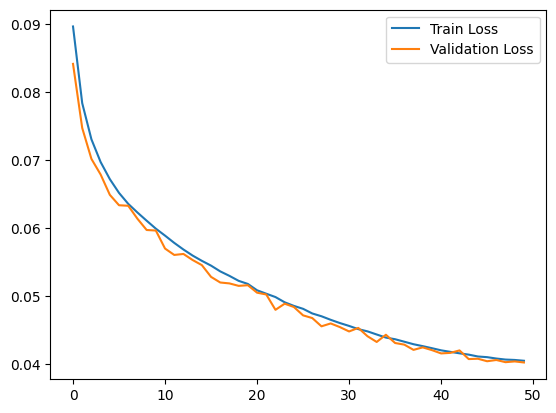

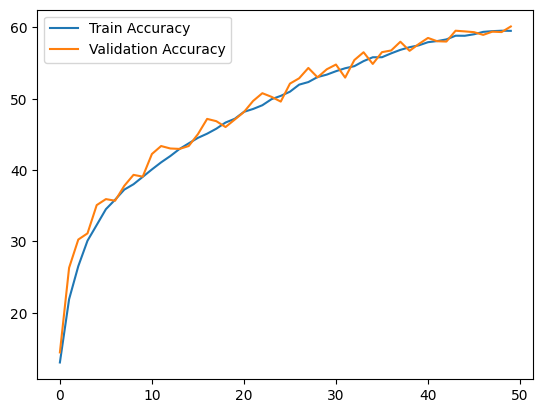

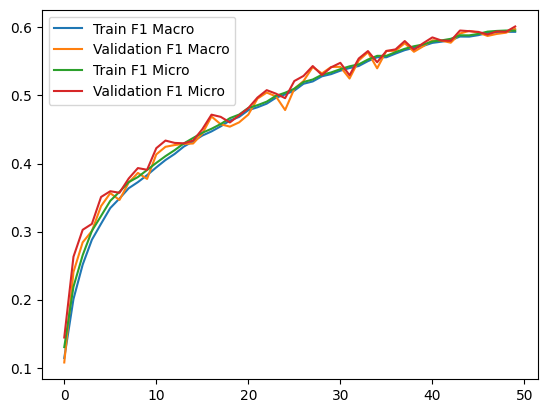

In [5]:
def training():
    transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/train', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/indian-birds-25/Birds_25/val', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print("Train Data: ", len(train_dataset))
    print("Validation Data: ", len(val_dataset))

    net = final_resnet(3, r, n, norm_type)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.00001)

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_f1_macro = []
    val_f1_macro = []
    train_f1_micro = []
    val_f1_micro = []

    print("------------------------Training Started------------------------")
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        for i, data in enumerate(tqdm(train_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        scheduler.step()
        train_loss.append(running_loss/total)
        train_accuracy.append((correct/total)*100)
        train_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        train_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        net.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        val_loss.append(running_loss/total)
        val_accuracy.append((correct/total)*100)
        val_f1_macro.append(f1_score(y_true, y_pred, average='macro'))
        val_f1_micro.append(f1_score(y_true, y_pred, average='micro'))

        print("Epoch: ", epoch, "Train Loss: ", train_loss[-1], "Train Accuracy: ", train_accuracy[-1], "Train F1 Macro: ", train_f1_macro[-1], "Train F1 Micro: ", train_f1_micro[-1])

        print("Epoch: ", epoch, "Validation Loss: ", val_loss[-1], "Validation Accuracy: ", val_accuracy[-1], "Validation F1 Macro: ", val_f1_macro[-1], "Validation F1 Micro: ", val_f1_micro[-1])

        print("---------------------------------------------------------------")

        with open('Part2-custom_groupnorm', 'a') as f:
            f.write("Epoch: " + str(epoch) + " Train Loss: " + str(train_loss[-1]) + " Train Accuracy: " + str(train_accuracy[-1]) + " Train F1 Macro: " + str(train_f1_macro[-1]) + " Train F1 Micro: " + str(train_f1_micro[-1]) + "\n")
            f.write("Epoch: " + str(epoch) + " Validation Loss: " + str(val_loss[-1]) + " Validation Accuracy: " + str(val_accuracy[-1]) + " Validation F1 Macro: " + str(val_f1_macro[-1]) + " Validation F1 Micro: " + str(val_f1_micro[-1]) + "\n")
            f.write("---------------------------------------------------------------\n")

    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(train_f1_macro, label='Train F1 Macro')
    plt.plot(val_f1_macro, label='Validation F1 Macro')
    plt.legend()

    plt.plot(train_f1_micro, label='Train F1 Micro')
    plt.plot(val_f1_micro, label='Validation F1 Micro')
    plt.legend()
    plt.show()

    torch.save(net.state_dict(), 'Part2-custom_normgroup.pth')
    
    
training()